<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/AutoencoderKaggle_pyimagesearch_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías

In [2]:
import PIL
import cv2
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

## Descarga de Datos

Nos descargamos las imágenes con un ancho de 256 de ancho. Vamos a ir escalando a 64, 128 y 256. Lo haremos con cv2.resize()

### Kaggle

**Descargamos un dataset de kaggle para aumentar el número de imágenes de prueba**

Tiene las siguientes clases:

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR


A nosotros nos intersan las de la clase 0. 







In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diegorudiezgomez","key":"a97ea3f0837ef30e1012d50ea0d74929"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
 ! chmod 600 ~/.kaggle/kaggle.json

**Tras relizar algunas configuraciones descargamos el dataset:**

In [8]:
%%time
! kaggle competitions download -c 'aptos2019-blindness-detection'

100% 9.50G/9.51G [00:57<00:00, 191MB/s]
100% 9.51G/9.51G [00:57<00:00, 177MB/s]
CPU times: user 888 ms, sys: 172 ms, total: 1.06 s
Wall time: 59.1 s


In [9]:
!unzip -qq aptos2019-blindness-detection.zip -d 'datasetKaggle'

In [3]:
datasetKaggle = 'datasetKaggle'

In [4]:
imgTrain = os.listdir(datasetKaggle + '/train_images')

In [5]:
datasetKaggle + '/train_images/' + imgTrain[0]

'datasetKaggle/train_images/2b07790a2422.png'

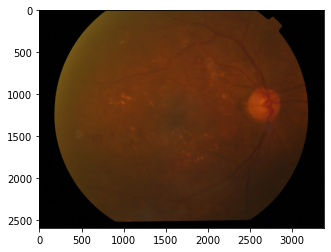

In [6]:
image = cv2.imread(datasetKaggle + '/train_images/' + imgTrain[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [7]:
df_trainKaggle = pd.read_csv(datasetKaggle + '/train.csv')

In [8]:
df_trainKaggle['diagnosis'].value_counts() #1805 imágenes sanas

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [14]:
df_trainKaggle.head(5)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


### Reto

**Ahora las del reto que hemos utilizado siempre.**

In [17]:
# !wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
# !wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
# !wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

In [18]:
# !rm -rvf Training_Set_Pre
# !unzip -qq train.zip #-qq no verbose
# !unzip -qq test.zip
# !unzip -qq val.zip

Descargamos el dataset sin procesar, para aplicar el mismo procesado a los dos datsets

In [19]:
!wget https://www.dropbox.com/s/1isaa8xrrv0x6n4/datasetComprimido.zip?dl=0 --no-verbose -O datasetComp.zip

2022-06-24 15:14:05 URL:https://uc01bd1f6a31485fc46d7d1b8ee6.dl.dropboxusercontent.com/cd/0/inline2/Bn1v3dyI-OJqj3m4NC4OkTurz2jsEloAr80O0yR_OJDRSB1OtAO0gdzArzYb1vWNpCaYmDKSdCWN3NqGRKJOggqrckdKUGUHb-fVou9qYlhTzMJQGytMx2qbxVx_wxULZAe6xZWmLIGikdZtNUPNUB3imwxrcZSG6AxnEc-3xmTBnSyTvUAY-FytuI729-TMWlMfP2AcEF1uY6VFOtquHVVMTZWDCJ6yJcSYe7N7aXHcifVw135hdFlnUagI_FpkIHGIYCTKayrfopYnjHNuV5cqAY8TstP_OIPTn9Qz2QaT9UQ8OHUJ6O8KSgiTjYKD5UzqXO9Hvqaxp3diKOrtgoxS2fI23jCQW05BPmAhV83QhE1JddlABvctGx6yfvEgse0rD20YsuQM0ulWFqhjLMHulz5xp6roW3OG2QzIkADzHg/file [144922725/144922725] -> "datasetComp.zip" [1]


In [20]:
!unzip -qq datasetComp.zip

In [21]:
# trainPath = 'Training_Set_Pre/'
# testPath  = 'Test_Set_Pre/'
# valPath  =  'Evaluation_Set_Pre/'

In [9]:
trainPath = 'Training_Set_C/'
testPath  = 'Test_Set_C/'
valPath  =  'Evaluation_Set_C/'

## Preparación de Datos

In [10]:
IMG_SIZE = 256

### Funciones de procesado

In [11]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted(image,4, cv2.GaussianBlur(image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

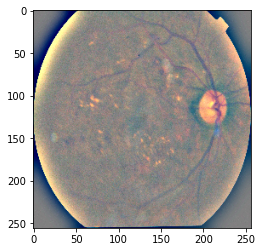

In [12]:
img = load_ben_color(datasetKaggle + '/train_images/' + imgTrain[0])
plt.imshow(img)

### Datos Kaggle

In [13]:
import shutil

def getNpArrayKaggle(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['id_code'], df['diagnosis']):
    # image = load_ben_color(pathO + '/' + str(id) + '.png', sigmaX=30)
    if(int(enf)==0):
      image = load_ben_color(pathO + '/' + str(id) + '.png')
      normal.append(np.asarray(image))
    # else:
    #   enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [14]:
normalKaggle, enfermedadKaggle = getNpArrayKaggle(df_trainKaggle, datasetKaggle + '/train_images')

In [15]:
normalKaggle.shape

(1805, 256, 256, 3)

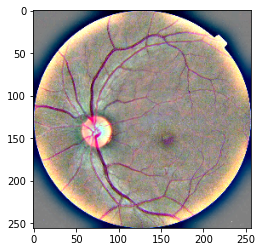

In [16]:
plt.imshow(normalKaggle[0])

### Datos Reto (el mismo de siempre)


In [17]:
import shutil

def getNpArray(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    image = load_ben_color(pathO + '/' + str(id) + '.png')
    if(int(enf)==0):
      normal.append(np.asarray(image))
    else:
      enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [18]:
df_train = pd.read_csv(trainPath + '/train.csv')
df_test = pd.read_csv(testPath + '/test.csv')
df_val = pd.read_csv(valPath + '/val.csv')

In [19]:
normalTrain, enfermedadTrain = getNpArray(df_train, trainPath + 'Training/')
normalTest, enfermedadTest = getNpArray(df_test, testPath + 'Test/')
normalVal, enfermedadVal = getNpArray(df_val, valPath + 'Validation/')

In [20]:
normalTrain.shape

(401, 256, 256, 3)

In [21]:
normalTest.shape

(134, 256, 256, 3)

Ya la tenemos reescalada a la medida deseada:

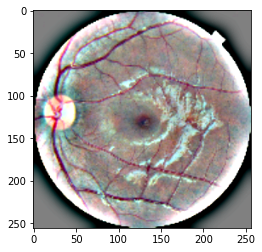

In [22]:
plt.imshow(normalTrain[0])

## Autoencoder pyimagesearch

https://pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/

In [94]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1
		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs
		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")
		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")
		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

### Train

In [97]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2

def build_unsupervised_dataset(data, labels, validLabel=1,
	anomalyLabel=3, contam=0.01, seed=42):
	# grab all indexes of the supplied class label that are *truly*
	# that particular label, then grab the indexes of the image
	# labels that will serve as our "anomalies"
	validIdxs = np.where(labels == validLabel)[0]
	anomalyIdxs = np.where(labels == anomalyLabel)[0]
	# randomly shuffle both sets of indexes
	random.shuffle(validIdxs)
	random.shuffle(anomalyIdxs)
	# compute the total number of anomaly data points to select
	i = int(len(validIdxs) * contam)
	anomalyIdxs = anomalyIdxs[:i]
	# use NumPy array indexing to extract both the valid images and
	# "anomlay" images
	validImages = data[validIdxs]
	anomalyImages = data[anomalyIdxs]
	# stack the valid images and anomaly images together to form a
	# single data matrix and then shuffle the rows
	images = np.vstack([validImages, anomalyImages])
	np.random.seed(seed)
	np.random.shuffle(images)
	# return the set of images
	return images

In [123]:
def visualize_predictions(decoded, gt, samples=10):
	# initialize our list of output images
	outputs = None
	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")
		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])
		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output
		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])
	# return the output images
	return outputs


In [99]:
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", type=str, required=True,
	help="path to output dataset file")
ap.add_argument("-m", "--model", type=str, required=True,
	help="path to output trained autoencoder")
ap.add_argument("-v", "--vis", type=str, default="recon_vis.png",
	help="path to output reconstruction visualization file")
ap.add_argument("-p", "--plot", type=str, default="plot.png",
	help="path to output plot file")
args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] -d DATASET -m MODEL [-v VIS] [-p PLOT]
ipykernel_launcher.py: error: the following arguments are required: -d/--dataset, -m/--model


SystemExit: ignored

In [104]:
images = build_unsupervised_dataset(normalKaggle, '', validLabel=1,
	anomalyLabel=3, contam=0.01)

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

In [105]:
images.shape

(0, 256, 256, 3, 1)

In [132]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(256, 256, 3)
opt = Adam(lr=0.0001, decay=0.0000001)
autoencoder.compile(loss="binary_crossentropy", optimizer=opt)
# train the convolutional autoencoder
H = autoencoder.fit(
	normalKaggle, normalKaggle,
	validation_data=(normalVal, normalVal),
	epochs=40,
	batch_size=64)
# use the convolutional autoencoder to make predictions on the
# testing images, construct the visualization, and then save it
# to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(normalTest)
vis = visualize_predictions(decoded, normalTest)
# cv2.imwrite(args["vis"], vis)

[INFO] building autoencoder...
Epoch 1/40
29/29 [==============================] - 9s 298ms/step - loss: -29.4498 - val_loss: -19.7193
Epoch 2/40
29/29 [==============================] - 9s 296ms/step - loss: -84.7762 - val_loss: -52.9241
Epoch 3/40
29/29 [==============================] - 9s 302ms/step - loss: -136.7908 - val_loss: -101.3547
Epoch 4/40
29/29 [==============================] - 9s 308ms/step - loss: -186.5932 - val_loss: -143.1878
Epoch 5/40
29/29 [==============================] - 9s 306ms/step - loss: -234.5171 - val_loss: -285.1939
Epoch 6/40
29/29 [==============================] - 9s 299ms/step - loss: -282.1015 - val_loss: -385.1268
Epoch 7/40
29/29 [==============================] - 9s 296ms/step - loss: -330.7874 - val_loss: -528.9865
Epoch 8/40
29/29 [==============================] - 9s 298ms/step - loss: -380.3382 - val_loss: -566.7122
Epoch 9/40
29/29 [==============================] - 8s 292ms/step - loss: -430.3178 - val_loss: -615.9424
Epoch 10/40
29/29 [

In [124]:
vis = visualize_predictions(decoded, normalTest)

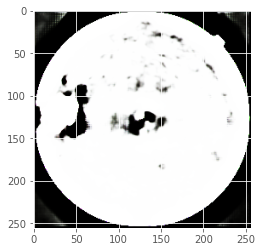

In [133]:
decoded = autoencoder.predict(normalTest)
plt.imshow(decoded[2])

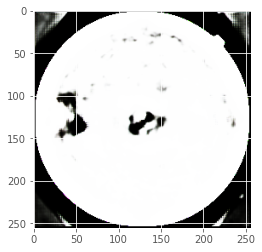

In [135]:
decoded = autoencoder.predict(enfermedadTest)
plt.imshow(decoded[10])